# Glacier Meltwater Runoff model
This notebook walks through modelling how meltwater will flow over a glacier and how it will change with different meltwater production.

### Imports

In [314]:
from landlab.components import (
    FlowDirectorD8,
    FlowDirectorMFD,
    FlowDirectorSteepest,
    FlowAccumulator, 
    SinkFillerBarnes,
    DepressionFinderAndRouter
)

from bmi_topography import Topography
from landlab import RasterModelGrid
from landlab.plot.drainage_plot import drainage_plot
from landlab.plot.graph import plot_graph
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.io
from scipy.ndimage import gaussian_filter

## Create Class for DEM and FlowAccumulator

In [55]:
class GlacierSurfaceFlow:
    '''
    Class to create model grid and FlowAccumulator for a glacier. Sets a grid for a given test case, creates a FlowAccumulator using the FlowDirectorD8 and contains 
    graphing functions to visualise the data.
    '''
    
    
    def __init__(self,case):        
        if case == 'Parabola':
            self.case = case
            self.grid = RasterModelGrid((10,10)) #create model grid
            self.elev = self.grid.add_field("topographic__elevation", self.grid.y_of_node+ 0.1 * (self.grid.x_of_node-4)**2, at="node") #add sloping parabola as elevation
        
        if case == 'Channel':
            self.case = case
            self.grid = RasterModelGrid((10,10)) #create model grid
            self.elev = self.grid.add_field("topographic__elevation", 1*self.grid.y_of_node, at="node") 
            self.elev[(self.grid.x_of_node > 2) & (self.grid.x_of_node < 4)] -=2 #add channel to topography
            
        if case == 'Nye Dome':
            self.case = case
            self.grid = RasterModelGrid((100,100)) #create model grid
            
            # calculate 
            z2 = 700 - 0.5*((self.grid.y_of_node-50)**2 + (self.grid.x_of_node-50)**2)
            z2[z2 <0]=0.1*np.random.rand(len(z2[z2<0]))
            elev = self.grid.add_field('topographic__elevation',np.sqrt(z2),at='node')
            
        if case == 'Andes':
            self.case = case
            self.topo = Topography(
                dem_type="SRTMGL1",
                south=-1.540602,
                north=-1.424255,
                west=-78.9056896,
                east=-78.753253,
                output_format="GTiff",
                cache_dir=".",
                api_key = 'b55f3a7af9257ddfe9dc41d960f443fa'
            )
            self.fname = self.topo.fetch()
            self.da = self.topo.load()
            self.grid = RasterModelGrid((self.da.shape[1:3]),xy_spacing=(30,30))
            self.grid.set_closed_boundaries_at_grid_edges(True, True, True, False)
            self.da = self.da.astype(np.float64) # type casting to float64, float32 will not work
            self.grid.add_field("topographic__elevation", np.flip(self.da,1), at="node"); # don't forget to f
        
    def create_flow_acc(self,flow_director='FlowDirectorD8',runoff_rate=None):
        self.fa = FlowAccumulator(self.grid,flow_director=flow_director,runoff_rate = runoff_rate)
        self.fa.run_one_step()
        self.da,self.q = self.fa.accumulate_flow()
    
    def surf_plot(self,surface='topographic__elevation', title=None):
        if title == None:
            title = f'Topography for {self.case}'
        plt.figure()
        ax=plt.axes(projection='3d')

        # plot the surface
        z = self.grid.at_node[surface].reshape(self.grid.shape)
        ax.plot_surface(
            self.grid.x_of_node.reshape(self.grid.shape),
            self.grid.y_of_node.reshape(self.grid.shape),
            z,
            rstride=1,
            cstride=1,
            cmap=cm.gray,
            linewidth=0.0,
            antialiased=False,
        )
        ax.view_init(elev=35,azim=-120)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('elevation')
        plt.title(title)
        plt.show()

## Plot synthetic glacier surfaces

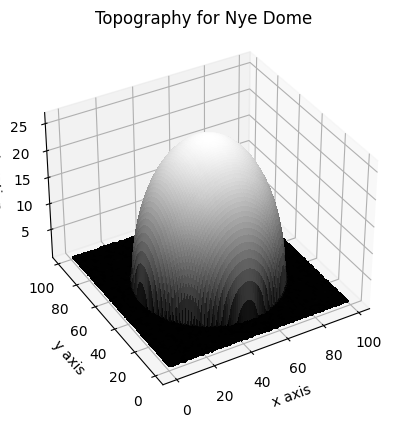

In [3]:
NyeDome = GlacierSurfaceFlow('Nye Dome')
NyeDome.surf_plot()

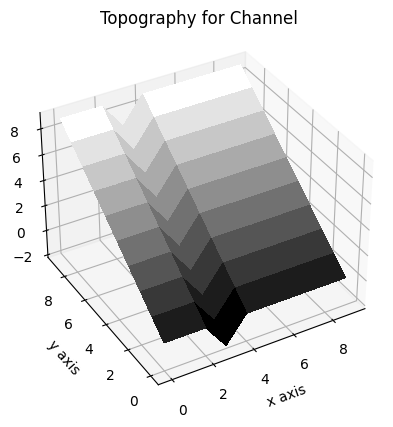

In [25]:
channel = GlacierSurfaceFlow('Channel')
channel.surf_plot()

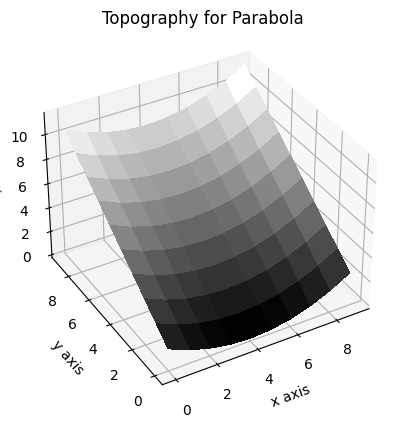

In [5]:
parabola = GlacierSurfaceFlow('Parabola')
parabola.surf_plot()

## Running flow accumulator on channel synthetic glacier

#### Instantiating class and plotting surface elevation

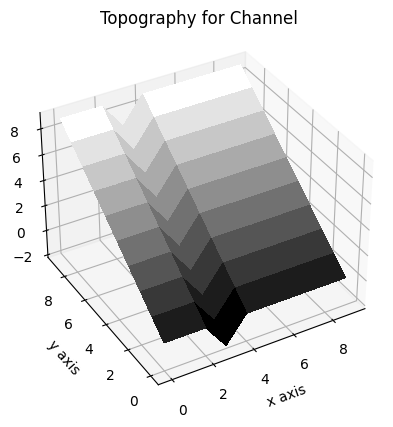

In [8]:
channel = GlacierSurfaceFlow('Channel')
channel.create_flow_acc()
channel.surf_plot()

#### Plotting drainage area

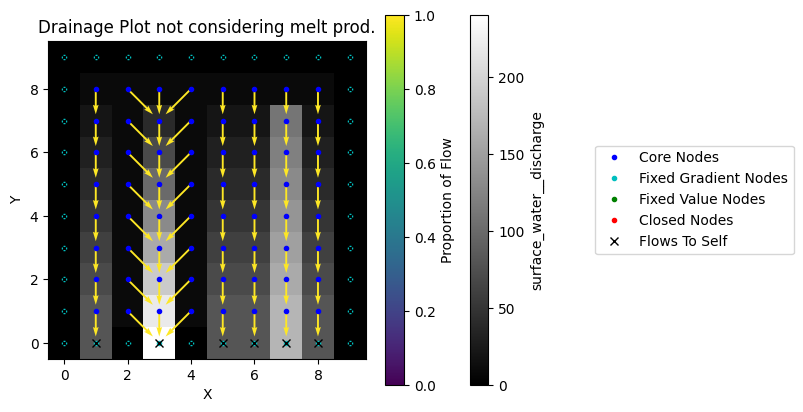

In [58]:
drainage_plot(channel.grid,surface='surface_water__discharge', title='Drainage Plot not considering melt prod.')
plt.show()

#### Incorporating heterogeneous melt production

In [31]:
runoff_rate = np.ones_like(channel.grid.at_node['water__unit_flux_in']) * 10
runoff_rate[(channel.grid.y_of_node==7) & (channel.grid.x_of_node==7)] = 100
channel.grid.at_node['water__unit_flux_in'] = runoff_rate

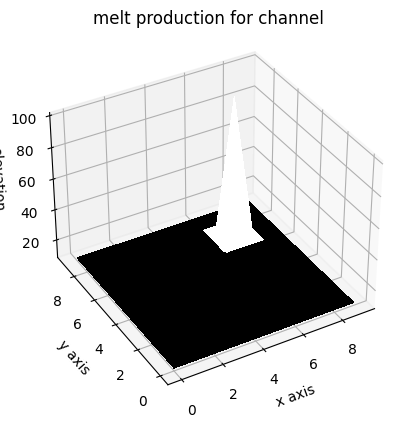

In [32]:
#channel.grid.at_node.keys()
channel.surf_plot(surface='water__unit_flux_in',title='melt production for channel')

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


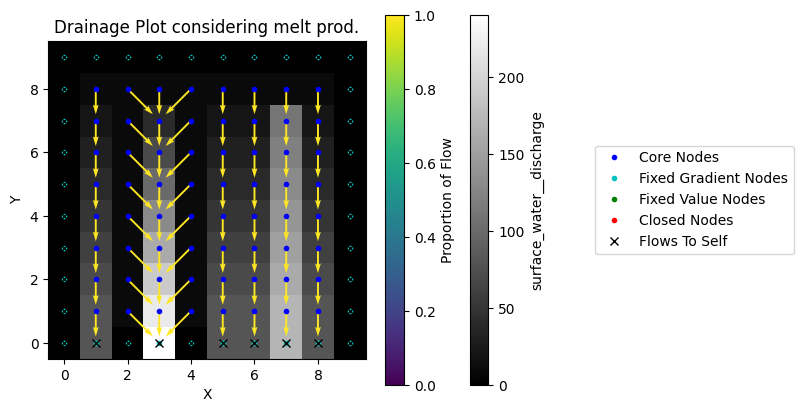

In [33]:
channel.create_flow_acc(runoff_rate = runoff_rate)
drainage_plot(channel.grid,surface='surface_water__discharge',title='Drainage Plot considering melt prod.')
plt.show()

## Running flow accumulator on Andes DEM

#### Instantiating class and plotting surface elevation

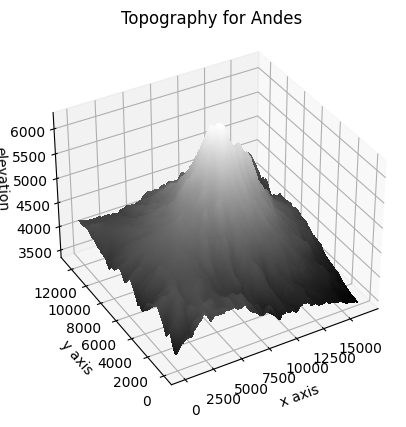

In [303]:
andes = GlacierSurfaceFlow('Andes')
andes.create_flow_acc()
andes.surf_plot()

#### Plotting drainage area

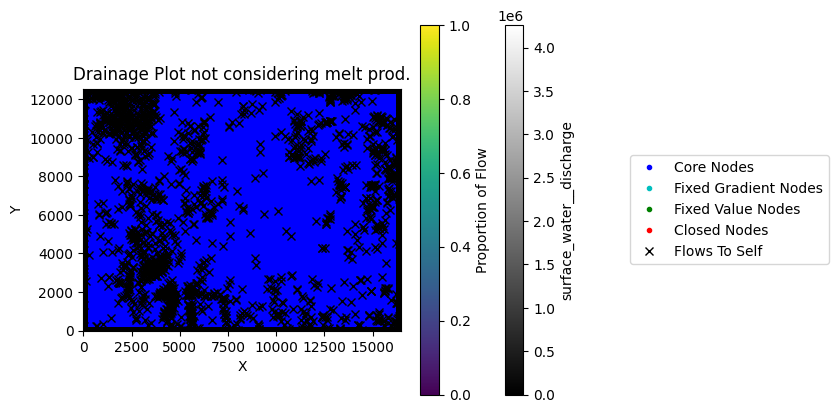

In [304]:
drainage_plot(andes.grid,surface='surface_water__discharge',title='Drainage Plot not considering melt prod.')
plt.show()

#### Incorporating heterogeneous melt production

In [310]:
snowmelt = xr.open_dataset('andes_ERA5_data.nc').smlt.mean(dim=['time'])
runoff_rate = andes.grid.add_ones('water__unit_flux_in',at='node',clobber=True)

runoff_rate[(andes.grid.y_of_node >= andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node >= andes.grid.x_of_node.max()/2)] = snowmelt[1][1]
runoff_rate[(andes.grid.y_of_node >= andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node < andes.grid.x_of_node.max()/2)] = snowmelt[1][0]
runoff_rate[(andes.grid.y_of_node < andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node >= andes.grid.x_of_node.max()/2)] = snowmelt[0][1]
runoff_rate[(andes.grid.y_of_node < andes.grid.y_of_node.max()/2) & (andes.grid.x_of_node < andes.grid.x_of_node.max()/2)] = snowmelt[0][0]

runoff_rate = gaussian_filter(andes.grid.at_node['water__unit_flux_in'].reshape(andes.grid.shape),100)
andes.grid.at_node['water__unit_flux_in'] = runoff_rate.reshape(andes.grid.shape)
#np.flip(runoff_rate,axis=1)

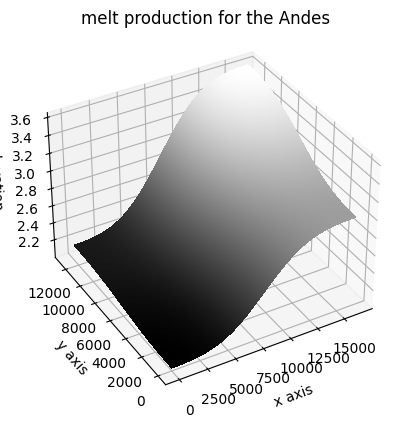

In [311]:
andes.surf_plot(surface='water__unit_flux_in',title = 'melt production for the Andes')

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


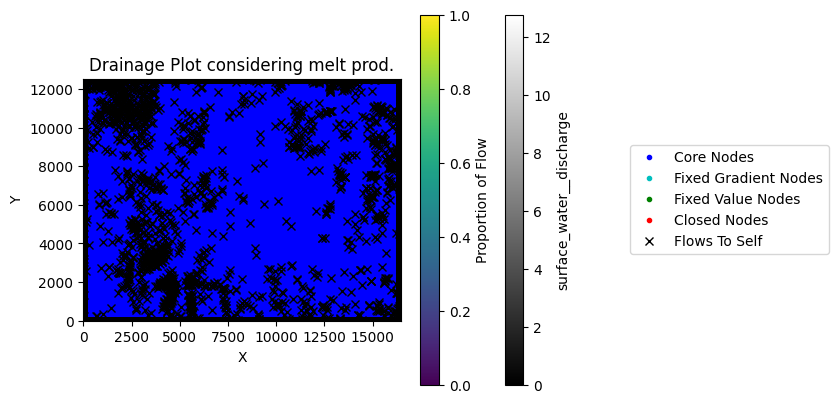

In [313]:
andes.create_flow_acc(runoff_rate = runoff_rate)
drainage_plot(andes.grid,surface='surface_water__discharge',title='Drainage Plot considering melt prod.')
plt.show()